<a href="https://colab.research.google.com/github/Daniel-Benson-Poe/DS-Unit-2-Kaggle-Challenge/blob/master/db_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
# Check Pandas Profiling version
!pip install pandas-profiling==2.*
import pandas_profiling

     |████████████████████████████████| 245kB 2.7MB/s 
     |████████████████████████████████| 8.7MB 14.8MB/s 
     |████████████████████████████████| 1.5MB 37.2MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 614kB 47.3MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 296kB 49.5MB/s 
  Created wheel for tangled-up-in-unicode: filename=tangled_up_in_unicode-0.0.4-cp36-none-any.whl size=1545723 sha256=daf1c797fac29044ba9dcd8b43482bdb529cc80ed4696b6bb7908b1e91350349
  Stored in directory: /root/.cache/pip/wheels/f9/f1/84/923abc0c2a75358b0bc28f87de02c7aa328c731ce68317d97d
  Created wheel for confuse: filename=confuse-1.1.0-cp36-none-any.whl size=17574 sha256=d32511a38124647eaad7e29fea41b27469f94ba33d6fdcc3c07d7b900908309f
  Stored in directory: /root/.cache/pip/wheels/f6/8b/23/41a1b516f6d8d4cc81f5bdb55394a47cdbe9659c53668d3c9e
  Created

In [1]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.6.0'

In [5]:
# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [27]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8140409527789386


In [0]:
# Some imports
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [29]:
# Make pipeline
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier()
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='accuracy')
print(scores)

[0.79492474 0.79712269 0.80371653]


In [30]:
 scores.mean()

0.7985879845477554

In [31]:

# Let's try playing with the parameters of randomforestclassifier
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 5
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='accuracy')
print(scores)

[0.7963148  0.7996448  0.80106572 0.79917851 0.80694938]


In [13]:
scores.mean()

0.8047474747474748

In [32]:
%%time
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(max_depth=20, max_features=0.5242645312876425, n_estimators=159, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)

print(f'Train accuracy: {pipeline.score(X_train, y_train)}')

Train accuracy: 0.9563074463833755
CPU times: user 1min 21s, sys: 159 ms, total: 1min 21s
Wall time: 42.3 s


In [0]:

# Make our prediction
y_pred = pipeline.predict(X_val)

# Confusion Matrix

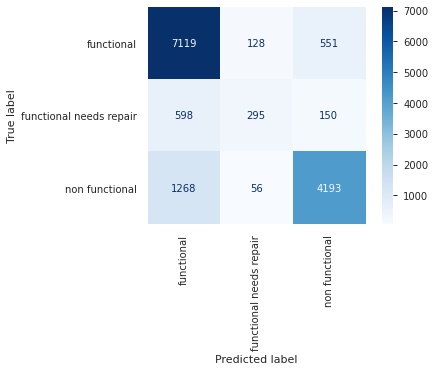

In [34]:
# import confusion matrix and plot our model onto a matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val,
                      xticks_rotation='vertical',
                      values_format='.0f',
                      cmap='Blues');

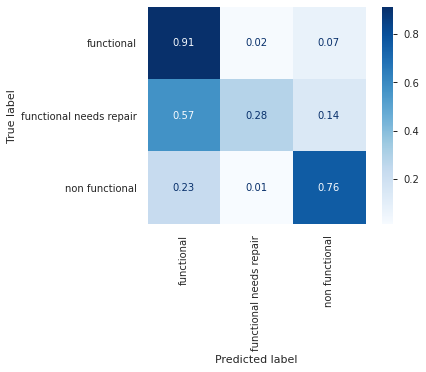

In [35]:
# Plot confusion matrix with normalized values
plot_confusion_matrix(pipeline, X_val, y_val,
                      xticks_rotation='vertical',
                      normalize='true',
                      values_format='.2f',
                      cmap='Blues');

In [36]:
# Print out matrix without the plot
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)
cm

array([[7119,  128,  551],
       [ 598,  295,  150],
       [1268,   56, 4193]])

In [37]:
# Print out normalized matrix without the plot
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
normalized_cm

array([[0.91292639, 0.01641447, 0.07065914],
       [0.57334612, 0.28283797, 0.14381592],
       [0.22983506, 0.01015044, 0.7600145 ]])

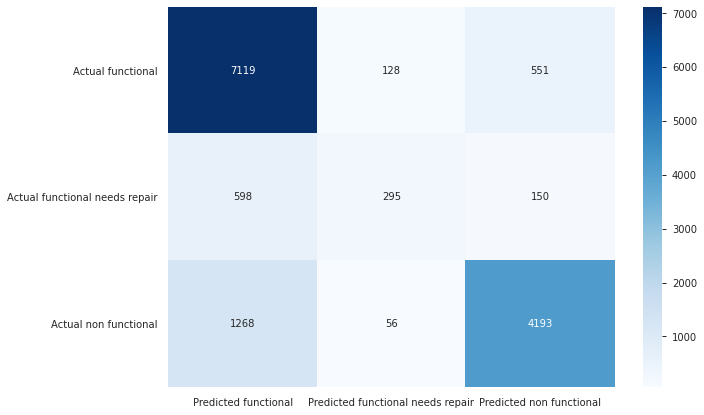

In [38]:
# Create a function for plotting a confusion matrix
import seaborn as sns
from sklearn.utils.multiclass import unique_labels

def plot_cm(y_val, y_pred, normalize=False):
  cols = unique_labels(y_val)
  cm = confusion_matrix(y_val, y_pred)
  if normalize:
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f'
  else:
    fmt = '.0f'
  df_cm = pd.DataFrame(cm,
                       columns=['Predicted ' + str(col) for col in cols],
                       index=['Actual ' + str(col) for col in cols])
  plt.figure(figsize=(10,7))
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt)

plot_cm(y_val, y_pred)

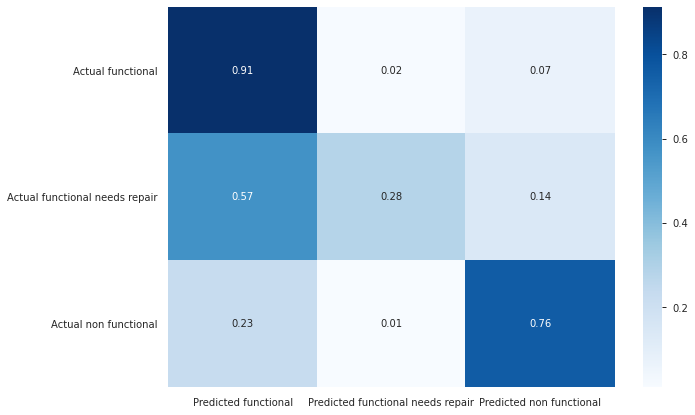

In [39]:
plot_cm(y_val, y_pred, normalize=True)

In [40]:
# Use classification metrics on our model
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.91      0.85      7798
functional needs repair       0.62      0.28      0.39      1043
         non functional       0.86      0.76      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.65      0.68     14358
           weighted avg       0.80      0.81      0.80     14358



In [41]:
# Compare that to our baseline
y_pred_baseline = ['functional']*len(y_pred)

print(classification_report(y_val, y_pred_baseline))

                         precision    recall  f1-score   support

             functional       0.54      1.00      0.70      7798
functional needs repair       0.00      0.00      0.00      1043
         non functional       0.00      0.00      0.00      5517

               accuracy                           0.54     14358
              macro avg       0.18      0.33      0.23     14358
           weighted avg       0.29      0.54      0.38     14358



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
